In [24]:
import numpy as np
import itertools
import sqlite3
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Motivation
![title](picture1.png)
![title](picture2.png)
My project is to build an artificial light harvesting system based on a protein assembly together with small molecule of dyes. As shown in the Picture1.png, the dye molecule is attached to the protein(purple ribbons) through a linking group. To achieve the higher efficiency of energy transfer, I want the dye to be locked into place. By employing different linker structures, I wish they can help restrict the motion of the dye over the surface of the protein. Before taking steps to synthesize those different linkers, molecular dynamics simulations were first undertaken to compare the conformational flexibility of chromophores together with linking groups. The simulation gave out a trajectory containing 2085 frames, each extracted during a fixed time interval. Based on the movie(ipr-2c.mpg) made up of all the trajectories, I found the protein backbone is quite rigid and the small molecule is very flexible. To simplify the problem, (please refer to the Picture2.png) I only focused on how one atom(the red N atom) move with respect to the backbone C alpha atom(orange atom).

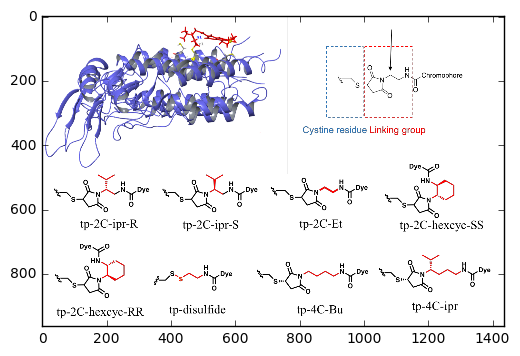

In [26]:
import matplotlib.image as mpimg
img=mpimg.imread('Picture1.png')
plt.imshow(img)

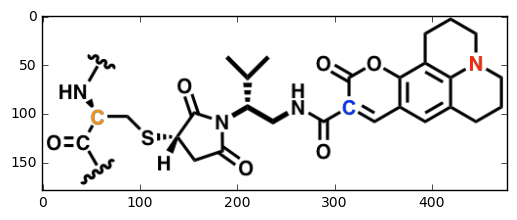

In [27]:
import matplotlib.image as mpimg
img=mpimg.imread('Picture2.png')
plt.imshow(img)

# Steps
1. Export all the data file and analyze the data file structures. There are three data files for each structure and will be illustrated in the following steps. The file type is pdb, which contains the position and identity information of my interested atoms.
2. Calculate coordinate transformation matrix

    Related file example: tp-2C-Et-superimpose.pdb; tp-2C-Et-full-CA.pdb
    
    The simulation of each structure is independent and the coordinate of the frames in each simulation does not share the same coordinate. Though all the trajectory frames for a single strucutre can be superimposed on the first frame in the trajectory by the software itself, the coordinates of different structures are not aligned. 
    To do a coordinate transformation: I superimposed all the backbone CA(alpha carbon) atoms in both the reference structure and the structure to be transformed(sample structure). The reference structure is tp-2C-ipr-R. Then I exported the coordinates of the two superimposed frames together in one file. The even number of rows in the superimposed file corresponds to one structure and the odd number of rows corresponds to the other. Three atoms in the two strucutrs were then selected to calculate the transformation matrix. The criteria for selecting the three atoms:When superimposed, the three atoms that were overlapped best between two frames. As shown in the picture below, the orange atoms represents all the backbone C alpha atoms in the reference strucutre and the blue atoms represents all the C alpha atoms in the sample structure. The closet three sets of atoms in each pair of superimposed structures were selected. 
    
    The {}-full-CA.pdb file has the imformation of all the C alpha atoms in the first frame of trajectories for each structure. After selection of the three atoms, I can then get the identity information of them and back track the coordinate of them from full-CA.pdb of reference and sample structure.
    
    ![title](superimpose.png)
    
3. Update the coordinate information

    Related file example: tp-2C-Et-couCN-CA.pdb
    These files extracts the information of my interested atoms(C alpha atom, blue C atom and red N atom) from all the 2085 frames. The coordinates of these atoms were first updated using the coordinate transformation matrix. In this way, the comparison of the motion led by different linkers can make sense under the same coordinate. 

4. Store all the atom information into a database

    The database stores the structure name, frame id, PDB type(to tell the element and type of atoms), residue type and number(the information of protein sequence) and x,y,z coordinate

5. Select the coordinate information from database and data visualization.(A detailed analysis and discussion of the data visulization can be found later together with the plots)

In [2]:
# Structures list contains the name of all the studied structures
structures = ['tp-2C-ipr-R', 
              'tp-2C-ipr-S',
              'tp-2C-Et',
              'tp-2C-hexcyc-SS',
              'tp-2C-hexcyc-RR',
              'tp-disulfide',
              'tp-4C-Bu',
              'tp-4C-ipr']
# Startline list contains the number of the line with which to start reading and extracting atom information
startline = [6,6,6,5,4,5,5,5]
# First, get the information of the backbone position of the reference structure(tp-2C-ipr-R)
CA_refer = np.genfromtxt('data/tp-2C-ipr-R/tp-2C-ipr-R-full-CA.pdb',skip_header = 122, usecols=(2,3,4,5,7,11,14),
                            dtype=None, invalid_raise= False)
connection = sqlite3.connect("cpTMV-linker-C343.db")
cursor = connection.cursor()
sql_cmd = """CREATE TABLE atom_sum (name TEXT, frameid INT, PDBtype TEXT,
    residue TEXT, resnumber INT, xcoord FLOAT, ycoord FLOAT, zcoord FLOAT)"""
cursor.execute(sql_cmd)
# The warning messages pop up because in the middle/end of the file, there are lines with missing columns.
# To ignore these lines, I set the invalid_raise as False to avoid raising an error but will still get the warning message

/Users/flyflyjean/anaconda/lib/python3.5/site-packages/numpy/lib/npyio.py:1772: ConversionWarning: Some errors were detected !
    Line #546 (got 1 columns instead of 7)
    Line #547 (got 1 columns instead of 7)
    Line #548 (got 1 columns instead of 7)
  warnings.warn(errmsg, ConversionWarning)


In [3]:
# The reference structrue is tp-2c-ipr-R.
# Firstly, the information of the reference structrue was saved into the database.
with open('data/{0}/{0}-couCN-CA.pdb'.format(structures[0]), 'rb') as f_in:
        cysCA = np.genfromtxt(itertools.islice(f_in, startline[0], None, 6), usecols = [2,3,5,6,7,8],
                              dtype = None, invalid_raise= False)
with open('data/{0}/{0}-couCN-CA.pdb'.format(structures[0]), 'rb') as f_in:
        couC = np.genfromtxt(itertools.islice(f_in, (startline[0]+2), None, 6), usecols = [2,3,4,5,6,7],
                             dtype = None, invalid_raise= False)
with open('data/{0}/{0}-couCN-CA.pdb'.format(structures[0]), 'rb') as f_in:
        couN = np.genfromtxt(itertools.islice(f_in, (startline[0]+3), None, 6), usecols = [2,3,4,5,6,7],
                             dtype = None, invalid_raise= False)

for item in [cysCA, couC, couN]:
    n = 0
    for frame in item:
        datalist = (structures[0],
                    int(n),
                    str(frame[0].decode('UTF8')), 
                    str(frame[1].decode('UTF8')),
                    int(frame[2]),
                    float(frame[3]),
                    float(frame[4]),
                    float(frame[5]))
        n += 1
        connection = sqlite3.connect("cpTMV-linker-C343.db")
        cursor = connection.cursor()
        sql_cmd = ("""INSERT INTO atom_sum (name, frameid, PDBtype, residue, resnumber, 
               xcoord, ycoord, zcoord) VALUES """ + str(datalist))
    
        cursor.execute(sql_cmd)
        connection.commit()

In [4]:
# trans_coord is to calculate the transformation matrix
# It reads in the superimpose file and split into two sets of structures and then based on the distance
# select the three best overlapped atoms
def trans_coord(structure,CA_refer):
    superimpose = np.genfromtxt('data/{0}/{0}-superimpose.pdb'.format(structure), 
                                skip_header = 5, usecols=(2,3,4,5,6,7,8), dtype=None, invalid_raise= False)
    CA = np.genfromtxt('data/{0}/{0}-full-CA.pdb'.format(structure),skip_header = 121, usecols=(2,3,4,5,7,11,14),
                            dtype=None, invalid_raise= False)
    distance = []
    a = superimpose[::2]
    b = superimpose[1::2]
    for i in range(int(len(superimpose)/2)):
        distance.append((a[i][4]-b[i][4])**2 + (a[i][5]-b[i][5])**2 + (a[i][6]-b[i][6])**2)
        distance_sort = np.argsort(np.asarray(distance))
    for n in range(len(distance)-2):
        result = distance_sort[n:(n+3)]
        reference = np.concatenate((CA_refer[result]['f0'],CA_refer[result]['f1'],CA_refer[result]['f2']), axis = 0)
        reference = reference.reshape(3,3)
        three_points = np.concatenate((CA[result]['f0'],CA[result]['f1'],
                            CA[result]['f2']), axis = 0).reshape(3,3)
        trans = np.dot(reference,np.linalg.pinv(three_points))
        cond = np.linalg.cond(trans)
# The condition number is to tell whether the selected three points are linear dependent or not
        if cond < 1.5:
            break
    return trans, cond
    
        

In [5]:
def coord_update(structure, trans, startline = 6, columns = ['f3','f4','f5']):
    with open('data/{0}/{0}-couCN-CA.pdb'.format(structure), 'rb') as f_in:
        cysCA = np.genfromtxt(itertools.islice(f_in, startline, None, 6), usecols = [2,3,5,6,7,8],
                              dtype = None, invalid_raise= False)
    with open('data/{0}/{0}-couCN-CA.pdb'.format(structure), 'rb') as f_in:
        couC = np.genfromtxt(itertools.islice(f_in, (startline+2), None, 6), usecols = [2,3,4,5,6,7],
                             dtype = None, invalid_raise= False)
    with open('data/{0}/{0}-couCN-CA.pdb'.format(structure), 'rb') as f_in:
        couN = np.genfromtxt(itertools.islice(f_in, (startline+3), None, 6), usecols = [2,3,4,5,6,7],
                             dtype = None, invalid_raise= False)
    for atom in [cysCA, couC, couN]:
        new_coord = np.dot(trans,np.concatenate((atom['f3'],atom['f4'],atom['f5'])).reshape(3,len(atom)))
        atom['f3'] = new_coord[0]
        atom['f4'] = new_coord[1]
        atom['f5'] = new_coord[2]
    return cysCA, couC, couN

In [6]:
# store all the structures into database
for i in range(7):
    trans, cond = trans_coord(structures[i+1], CA_refer)
    cysCA, couC, couN = coord_update(structures[i+1], trans, startline = startline[i+1])
    for item in [cysCA, couC, couN]:
        n = 0
        for frame in item:
            datalist = (structures[i+1],
                    int(n),
                    str(frame[0].decode('UTF8')), 
                    str(frame[1].decode('UTF8')),
                    int(frame[2]),
                    float(frame[3]),
                    float(frame[4]),
                    float(frame[5]))
            n += 1
            connection = sqlite3.connect("cpTMV-linker-C343.db")
            cursor = connection.cursor()
            sql_cmd = ("""INSERT INTO atom_sum (name, frameid, PDBtype, residue, resnumber, 
               xcoord, ycoord, zcoord) VALUES """ + str(datalist))
    
            cursor.execute(sql_cmd)
            connection.commit()


/Users/flyflyjean/anaconda/lib/python3.5/site-packages/numpy/lib/npyio.py:1772: ConversionWarning: Some errors were detected !
    Line #288 (got 5 columns instead of 7)
    Line #571 (got 5 columns instead of 7)
    Line #854 (got 1 columns instead of 7)
    Line #855 (got 1 columns instead of 7)
  warnings.warn(errmsg, ConversionWarning)
/Users/flyflyjean/anaconda/lib/python3.5/site-packages/numpy/lib/npyio.py:1772: ConversionWarning: Some errors were detected !
    Line #122 (got 1 columns instead of 7)
    Line #546 (got 1 columns instead of 7)
    Line #547 (got 1 columns instead of 7)
    Line #548 (got 1 columns instead of 7)
  warnings.warn(errmsg, ConversionWarning)
/Users/flyflyjean/anaconda/lib/python3.5/site-packages/numpy/lib/npyio.py:1772: ConversionWarning: Some errors were detected !
    Line #288 (got 5 columns instead of 7)
    Line #571 (got 5 columns instead of 7)
  warnings.warn(errmsg, ConversionWarning)
/Users/flyflyjean/anaconda/lib/python3.5/site-packages/numpy

In [7]:
# Search in database based on the atom type and strucutre name and extract the interested information
# The backbone C alpha atom was set as the origin during analysis
atom_info = []
for i in range(8):
    sql_cmd = """SELECT atom_sum.xcoord, atom_sum.ycoord, atom_sum.zcoord FROM atom_sum WHERE 
    atom_sum.PDBtype = 'CA' AND atom_sum.name = '{}'""".format(structures[i])
    cursor.execute(sql_cmd)
    cysCA_data = cursor.fetchall()
    connection.commit()

    sql_cmd = """SELECT atom_sum.xcoord, atom_sum.ycoord, atom_sum.zcoord FROM atom_sum WHERE 
    atom_sum.PDBtype = 'C1' AND atom_sum.name = '{}'""".format(structures[i])
    cursor.execute(sql_cmd)
    couC_data = cursor.fetchall()
    connection.commit()

    sql_cmd = """SELECT atom_sum.xcoord, atom_sum.ycoord, atom_sum.zcoord FROM atom_sum WHERE 
    atom_sum.PDBtype = 'N1' AND atom_sum.name = '{}'""".format(structures[i])
    cursor.execute(sql_cmd)
    couN_data = cursor.fetchall()
    connection.commit()

    couC_coord = np.subtract(couC_data, cysCA_data)
    couN_coord = np.subtract(couN_data, cysCA_data)
    vector = np.subtract(couN_coord,couC_coord)
    
    atom_info.append([couC_coord, couN_coord, vector])


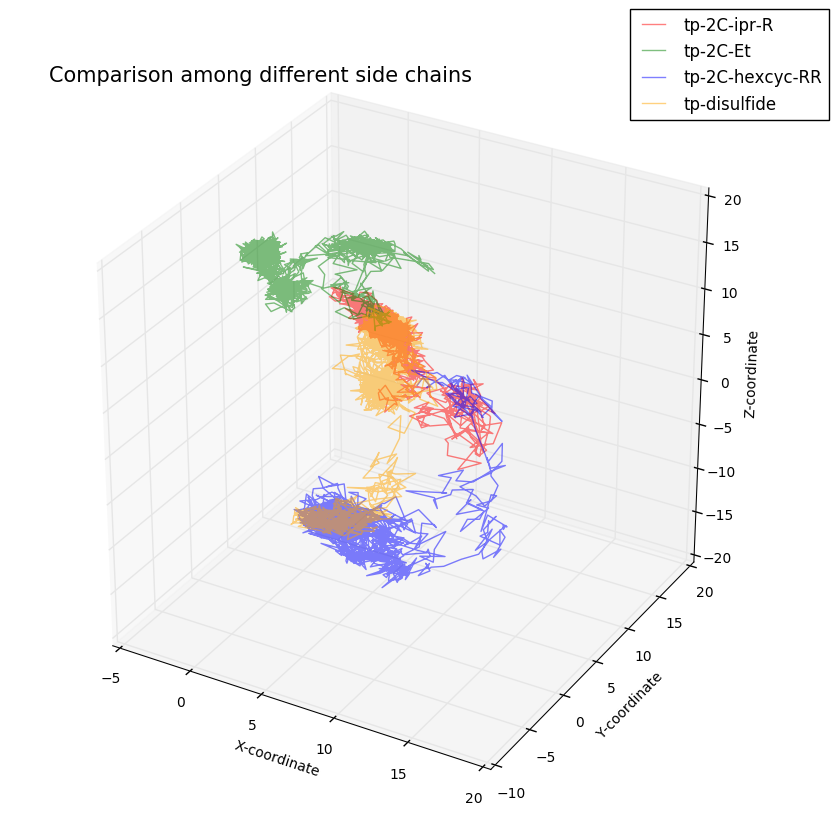

In [9]:
fig = plt.figure(figsize=(10,10))
color = ['red', 'green', 'blue', 'orange','purple']
axx = fig.add_subplot(111, projection='3d')
color_num = 0
for i in [0, 2, 4, 5] :
    x = atom_info[i][1][:,0]
    y = atom_info[i][1][:,1]
    z = atom_info[i][1][:,2]
    axx.plot(x, y, z, zdir = 'z', alpha = 0.5, color = color[color_num], label = structures[i])
    color_num += 1             
    axx.set_xlabel('X-coordinate', fontsize = 10)
    axx.set_ylabel('Y-coordinate', fontsize = 10)
    axx.set_zlabel('Z-coordinate', fontsize = 10)
    axx.legend(loc = (0.8,0.9))
axx.text2D(0.05, 0.95, "Comparison among different side chains", transform=axx.transAxes, fontsize = 15)

The backbone C alpha atom was set as the origin. The trajectory of N atoms was plotted above. By just looking at the above plot, I can hardly draw any reliable conclusion. I then analyzed each structure separately using four plots. The first one shows the path of N atoms. I found the all the paths has the same pattern, starting with random route and then fall into a more compact region. The initial irregular paths consisting of random positions suggest that the input structure is relatively instable and a significant amount of equilibration time was contributed before reaching an energy minimum while the followed tighter clusters indicate the fluctuation around one or two energetically favorable states. The second scatter plot was colormapped with respect to the time(actually in the color bar is the frame id, which is in proportion to the time). I made the dots to be transparent, so the density of the color can infer the population. This graph gave the same idea that the motion of atom can be described by two states, the initial state(shown in the plot as a looser cluster with more random positions) and a final state(shown in the plot a much more cluster). In the third plot, I used kmeans to classify the two states and color coded accordingly. Finally, I calcaulted the standard deviation of the final state and use this as a way to tell the flexibily. The standard deviation, as it defines the average ‘distance’ to the mean, provides a rough estimation to illustrate the dispersion, or in another word, the scope of movement.

When designing the linkers, I want to compare three properties:
1. linker length(tp-2C-Et vs tp-4C-Bu, tp-2C-ipr-R vs tp-4C-ipr)   
2. side chain type(a bulky side chain tp-2C-ipr; a ring side chian tp-2C-hexcyc; or a side chain which can keep the dihedral angle fixed at 90 degree tp-disulfide)
3. the chirality of the side chain(tp-2C-ipr-R vs tp-2C-ipr-S, tp-2C-hexcyc-SS vs tp-2C-hexcyc-RR)

And got some conclusions:
Among all the side chains, both S/R configuration of ipr side chains work very well to restrict the motion of the dye. Hexcyc-RR linker works similarly to 2C-ipr-R but its isomer hexcyc-SS, compared with the one without side chain(tp-2C-Et), making the dye more flexible instead. Since all the amino acid are also chiral and it seems reasonable that different chirality of the small molecule will greatly influence its interaction with the protein. A short linker will also increase the rigidity. The difference in 2C-ipr linker and 2C-Et linker is not tremendous, and with the linkers extending to four-carbon-long, the difference becomes much larger, which implies the two-carbon linker is already a rigid enough linker. The almost same value for Et linker and Bu-ipr linker suggests a bulky side chain exerts an equally effect as shortening the linker length by two carbons. 

In [14]:
from scipy.cluster.vq import vq, kmeans, whiten, kmeans2
def plotdata(n):
    fig = plt.figure(figsize=(10,10))
    color = ['red', 'green', 'blue', 'orange','purple']
    color_num = 0
    x = atom_info[n][1][:,0]
    y = atom_info[n][1][:,1]
    z = atom_info[n][1][:,2]
    data_whiten = whiten(atom_info[n][1])
    centroids, closest_centroids = kmeans2(data_whiten,2, minit = 'points')
    state1_indices = np.nonzero(closest_centroids)
    state2_indices = np.where(closest_centroids==0)[0]
    if np.mean(state1_indices) > np.mean(state2_indices):
        init_indices = state2_indices
        final_indices = state1_indices
    else:
        init_indices = state1_indices
        final_indices = state2_indices
    init_state = atom_info[n][1][init_indices]
    final_state = atom_info[n][1][final_indices]

    axx1 = fig.add_subplot(2,2,1, projection='3d')
    axx1.set_xlabel('X-coordinate', fontsize = 10)
    axx1.set_ylabel('Y-coordinate', fontsize = 10)
    axx1.set_zlabel('Z-coordinate', fontsize = 10)
    axx1.plot(x, y, z, zdir = 'z')
    axx1.text2D(0.05, 0.95, "{} N atom trajectory".format(structures[n]), transform=axx1.transAxes, fontsize = 12)

    axx2 = fig.add_subplot(2,2,2, projection='3d')
    axx2.set_xlabel('X-coordinate', fontsize = 10)
    axx2.set_ylabel('Y-coordinate', fontsize = 10)
    axx2.set_zlabel('Z-coordinate', fontsize = 10)
    scat = axx2.scatter(x, y, z, zdir = 'z', alpha = 0.1, c = np.arange(len(x)))
    fig.colorbar(scat)
    axx2.text2D(0.05, 0.95, '{} N atom scatter plot'.format(structures[n]), transform=axx2.transAxes, fontsize = 12)

    axx3 = fig.add_subplot(2,2,3, projection='3d')
    axx3.set_xlabel('X-coordinate', fontsize = 10)
    axx3.set_ylabel('Y-coordinate', fontsize = 10)
    axx3.set_zlabel('Z-coordinate', fontsize = 10)
    axx3.scatter(init_state[:,0],init_state[:,1],init_state[:,2], zdir = 'z', alpha = 0.5, label = 'initial state',
             c = 'red', marker = 'o', edgecolor = 'none')
    axx3.scatter(final_state[:,0],final_state[:,1],final_state[:,2], zdir = 'z', alpha = 0.5, label = 'final state',
             c = 'blue', edgecolor = 'none')
    #scat2 = axx3.scatter(x, y, z, zdir = 'z', alpha = 0.5, c=closest_centroids, label = structures[i])
    axx3.text2D(0.00, 0.95, '{} N atom kmeans clusters'.format(structures[n]), transform=axx3.transAxes, fontsize = 12)
    axx3.legend(frameon = False, fontsize = 10, loc =(0.6,0.8))

    axx4 = fig.add_subplot(2,2,4, projection='3d')
    axx4.set_xlabel('X-coordinate', fontsize = 10)
    axx4.set_ylabel('Y-coordinate', fontsize = 10)
    axx4.set_zlabel('Z-coordinate', fontsize = 10)
    axx4.scatter(final_state[:,0],final_state[:,1],final_state[:,2], zdir = 'z', alpha = 0.5, label = 'final state',
             c = 'blue', edgecolor = 'none')
    center = np.mean(final_state, axis = 0)
    std = np.std(final_state, axis = 0)
    r = math.sqrt(std[0]**2 + std[1]**2 + std[2]**2)
    axx4.text2D(0.00, 0.95, '{} atom final state standard deviation'.format(structures[n]), 
                transform=axx4.transAxes, fontsize = 12)
    axx4.text2D(0.2, 0.8, 'standard deviation: %.2f' % r, transform=axx4.transAxes, fontsize = 12)


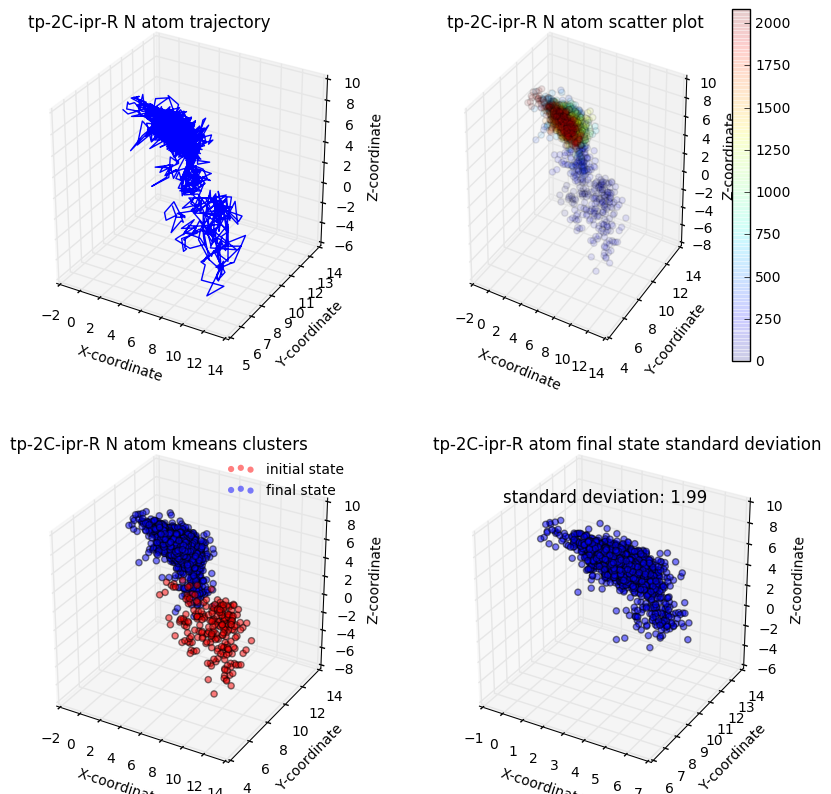

In [15]:
plotdata(0)

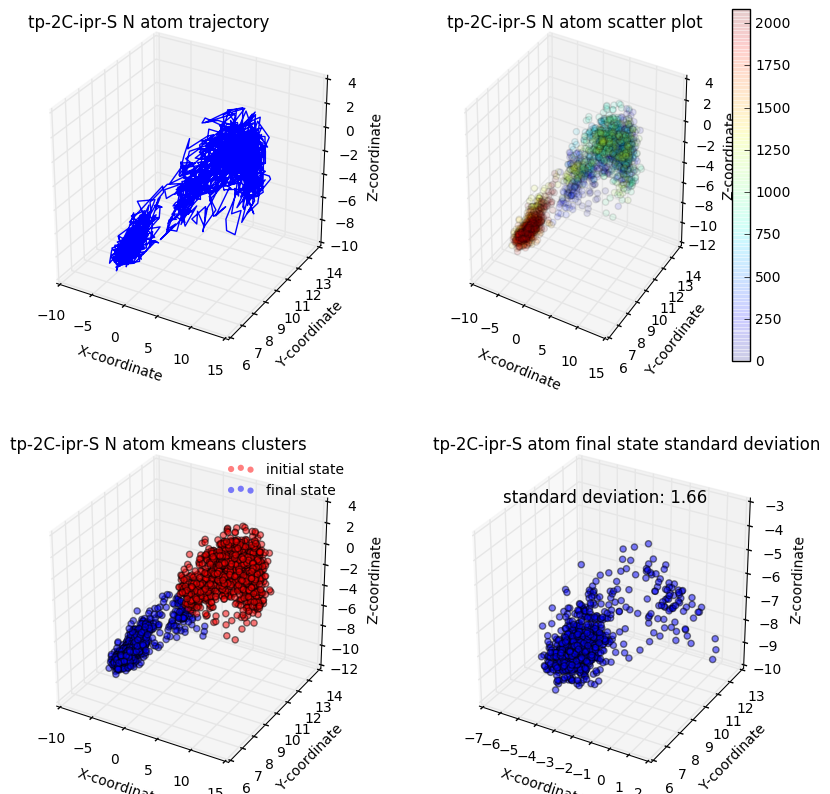

In [16]:
plotdata(1)

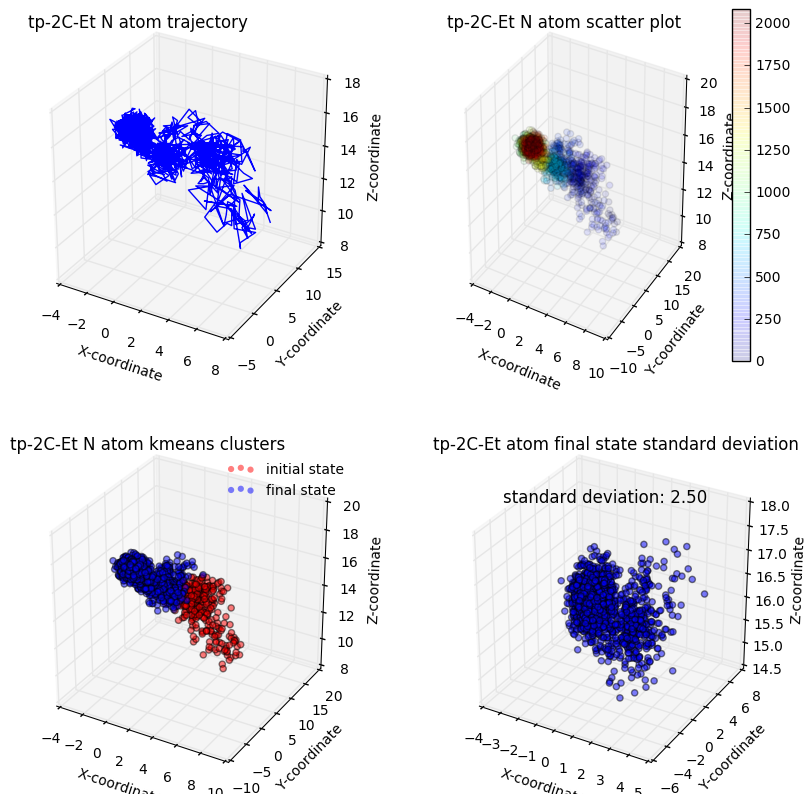

In [17]:
plotdata(2)

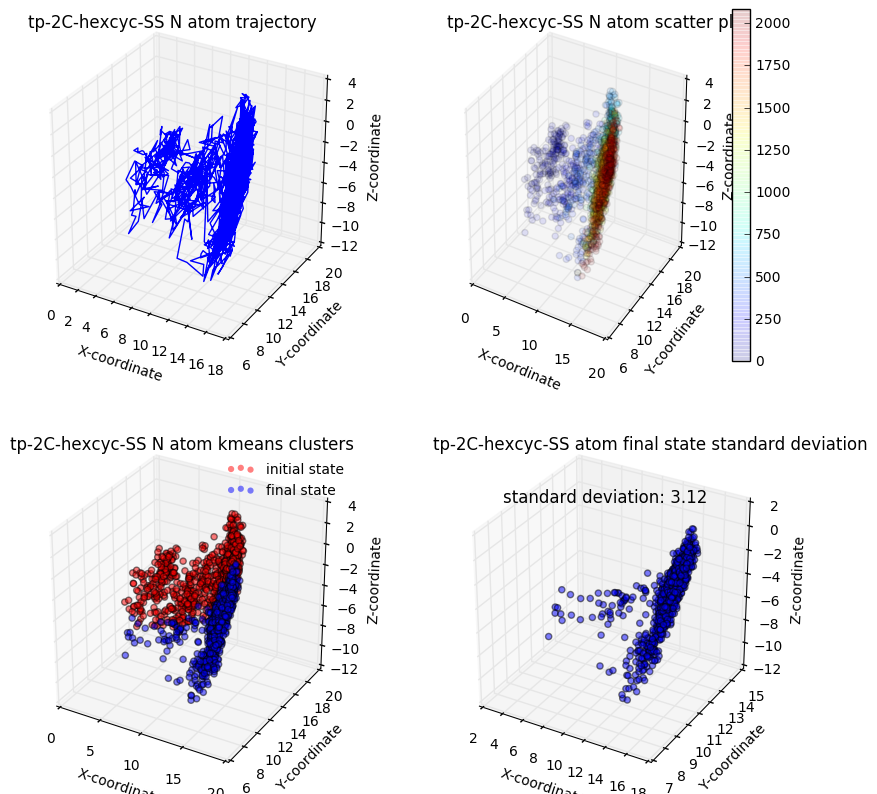

In [19]:
plotdata(3)

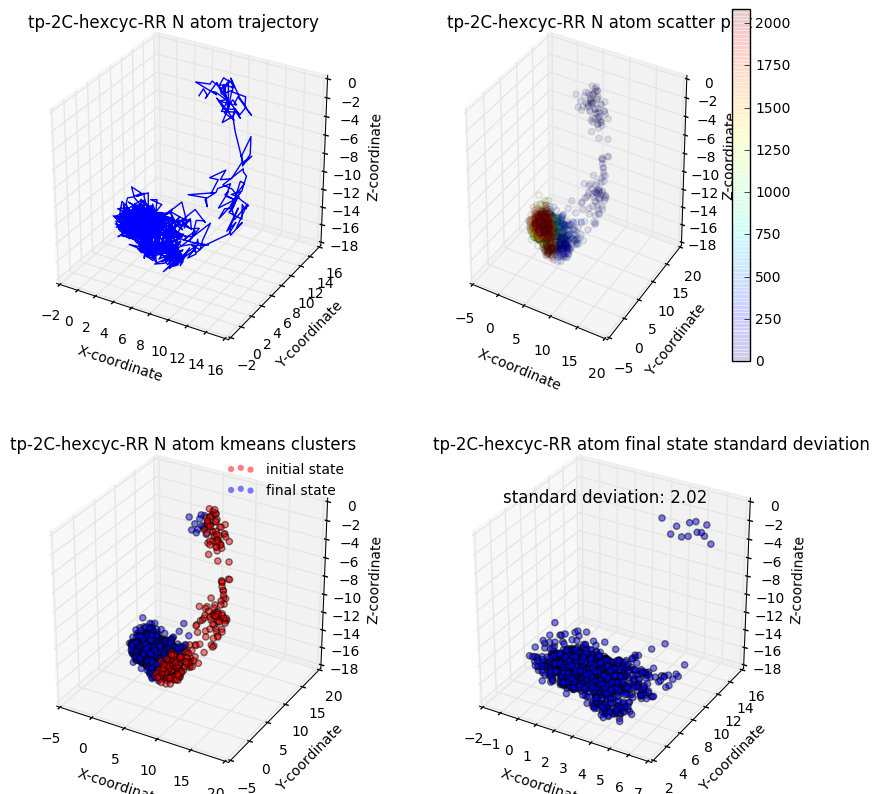

In [20]:
plotdata(4)

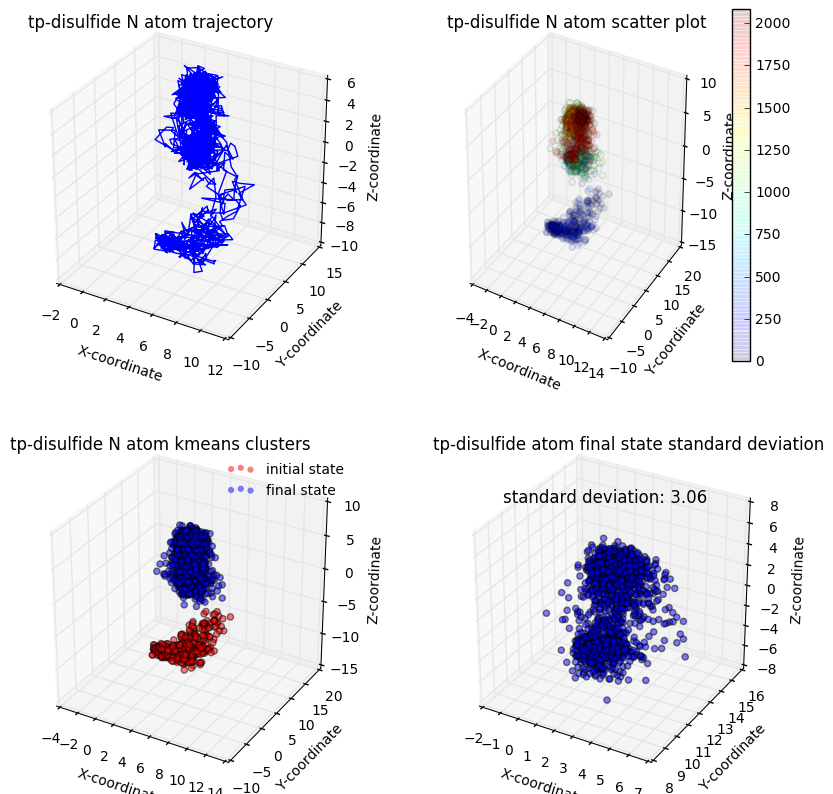

In [21]:
plotdata(5)

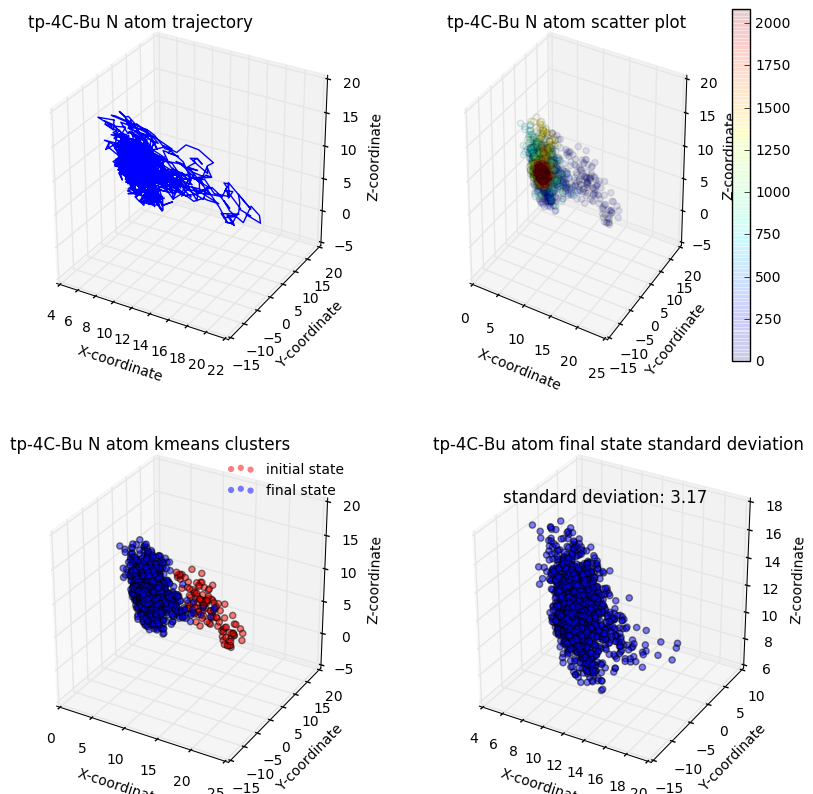

In [22]:
plotdata(6)

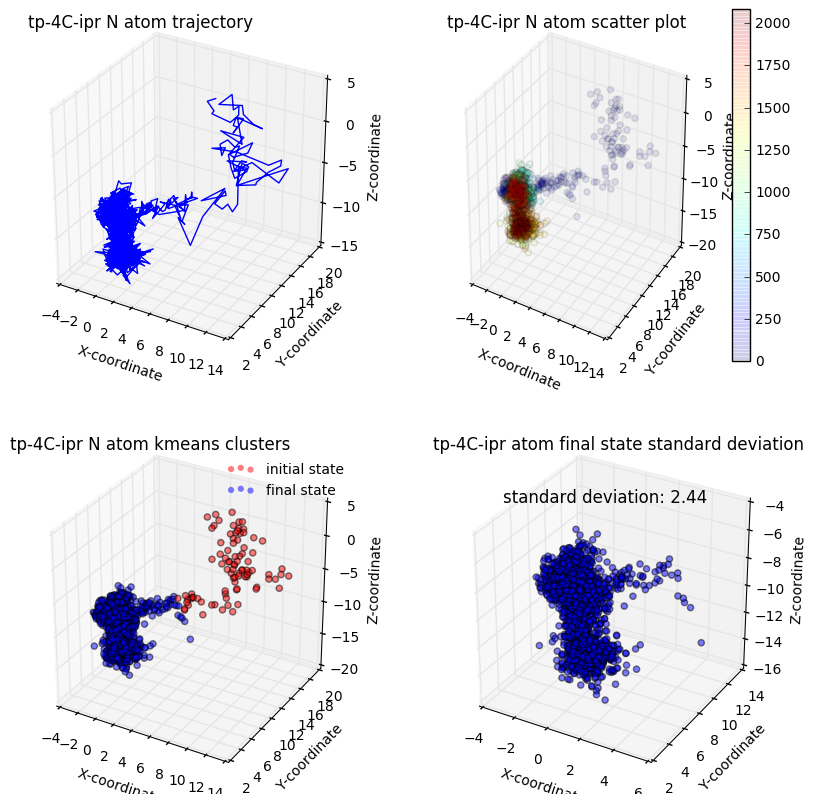

In [23]:
plotdata(7)